In [1]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

transform = transforms.Compose([
    transforms.Resize((64,64,)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [3]:
train_size = int(0.8* len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [4]:
batch_size = 128  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)


In [6]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# úprava poslední vrstvy
num_classes = len(full_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# definuj device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
num_epochs = 2  # začneme s 2 epochami

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"[{epoch+1}/{num_epochs}] Loss: {running_loss:.4f} | Accuracy: {train_accuracy:.2f}%")

    # Validace
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    print(f"  🔍 Val Accuracy: {val_accuracy:.2f}%\n")


[1/2] Loss: 73.0188 | Accuracy: 96.03%
  🔍 Val Accuracy: 97.66%

[2/2] Loss: 16.4568 | Accuracy: 99.16%
  🔍 Val Accuracy: 99.76%



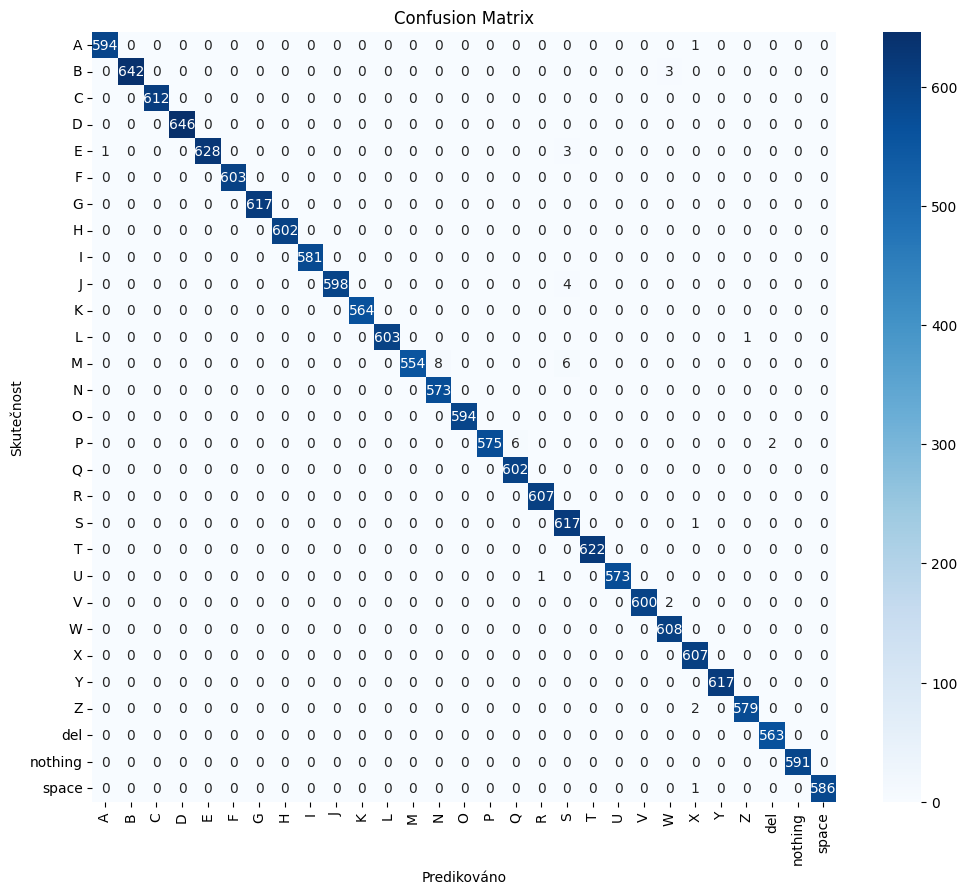

In [11]:
# Confusion Matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for val_inputs, val_labels in val_loader:
        val_inputs = val_inputs.to(device)
        outputs = model(val_inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(val_labels.numpy())

# Vykresli confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel("Predikováno")
plt.ylabel("Skutečnost")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [12]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))


              precision    recall  f1-score   support

           A       1.00      1.00      1.00       595
           B       1.00      1.00      1.00       645
           C       1.00      1.00      1.00       612
           D       1.00      1.00      1.00       646
           E       1.00      0.99      1.00       632
           F       1.00      1.00      1.00       603
           G       1.00      1.00      1.00       617
           H       1.00      1.00      1.00       602
           I       1.00      1.00      1.00       581
           J       1.00      0.99      1.00       602
           K       1.00      1.00      1.00       564
           L       1.00      1.00      1.00       604
           M       1.00      0.98      0.99       568
           N       0.99      1.00      0.99       573
           O       1.00      1.00      1.00       594
           P       1.00      0.99      0.99       583
           Q       0.99      1.00      1.00       602
           R       1.00    

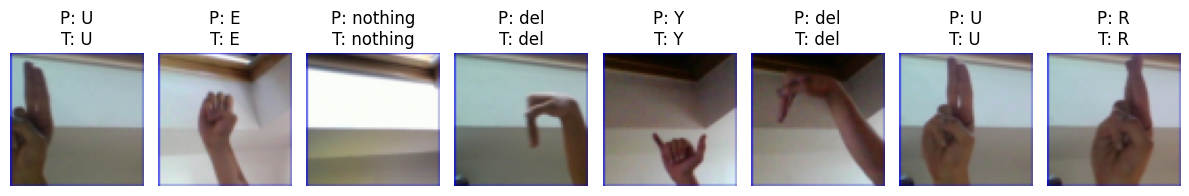

In [9]:
import matplotlib.pyplot as plt

model.eval()
class_names = full_dataset.classes

def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.title(title)
    plt.axis('off')

# Zobrazíme 8 obrázků a jejich predikce
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Vykresli prvních 8
plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(1, 8, i+1)
    imshow(images[i].cpu(), f"P: {class_names[predicted[i]]}\nT: {class_names[labels[i]]}")
plt.tight_layout()
plt.show()
